In [1]:
# 필요한 라이브러리 설치
!pip install -q tensorflow seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.17.0


In [2]:
# 데이터 로드
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

# 결측값 제거
dataset = raw_dataset.dropna()

# 범주형 변수 처리
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

# 데이터 분할
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 특성과 레이블 분리
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')


<ipython-input-2-e9de164974c0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [4]:
# 정규화 레이어
normalizer = layers.Normalization()
normalizer.adapt(np.array(train_features))

# 정규화 레이어 상태 확인
print("Normalizer mean:", normalizer.mean.numpy())


Normalizer mean: [[5.4777069e+00 1.9531847e+02 1.0486943e+02 2.9902517e+03 1.5559236e+01
  7.5898087e+01 1.7834395e-01 1.9745223e-01 6.2420380e-01]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


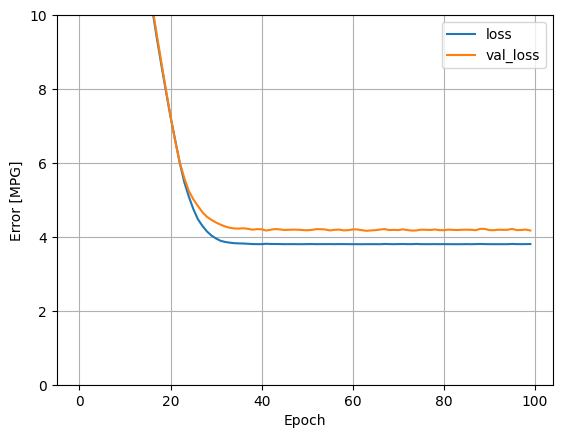

In [5]:
# 단일 변수 선형 회귀
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                         loss='mean_absolute_error')

# 모델 훈련
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    validation_split=0.2,
    verbose=0
)

# 훈련 과정 시각화
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)


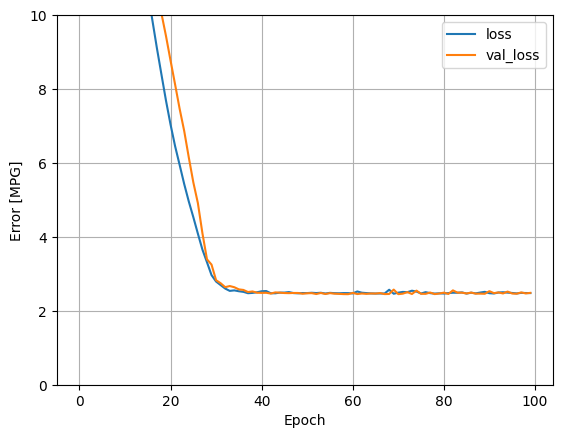

In [6]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                     loss='mean_absolute_error')

# 모델 훈련
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    validation_split=0.2,
    verbose=0
)

# 훈련 과정 시각화
plot_loss(history)

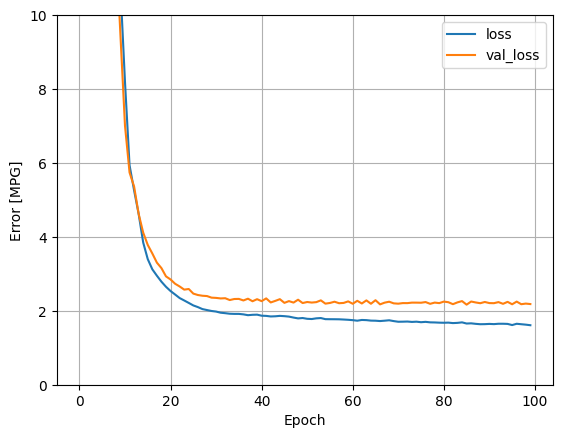

In [8]:
# DNN 모델 정의
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

# DNN 모델 훈련 (단일 입력 변수)
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

# DNN 모델 훈련 (다중 입력 변수)
dnn_model = build_and_compile_model(normalizer)
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

# 훈련 과정 시각화
plot_loss(history)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


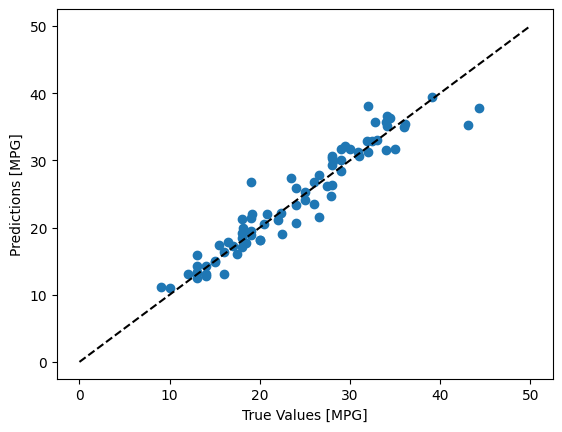

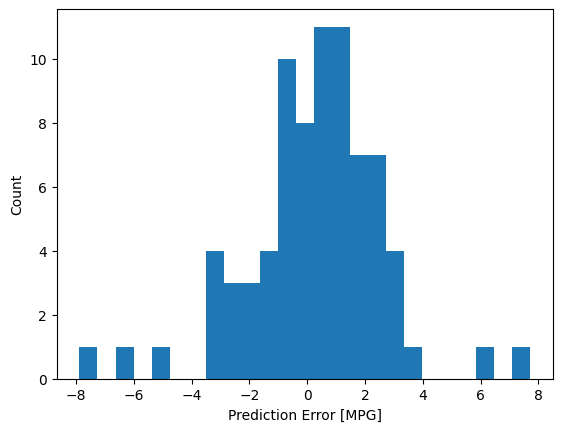

In [9]:
# 모델 평가
test_results = {}
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# 결과 출력
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

# 예측 시각화
test_predictions = dnn_model.predict(test_features).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.plot([0, 50], [0, 50], 'k--')
plt.show()

# 예측 오류 분포 시각화
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')
plt.show()
